# How to think in JAX

JAX provides a simple and powerful API for writing accelerated numerical code,
but working effectively in JAX sometimes requires extra consideration.
This document is meant to help build a ground-up understanding of how JAX operates,
so that you can use it more effectively.

## JAX vs. NumPy

**Key Concepts:**

- JAX provides a NumPy-inspired interface for convenience.
- Through duck-typing, JAX arrays can often be used as drop-in replacements of NumPy arrays.
- Unlike NumPy arrays, JAX arrays are always immutable.

NumPy provides a well-known, powerful API for working with numerical data.
For convenience, JAX includes the `jax.numpy` module, which closely mirrors the
NumPy API and provides easy entry into JAX. Here are some operations you might do in `numpy`:


In [1]:
import matplotlib.pyplot as plt

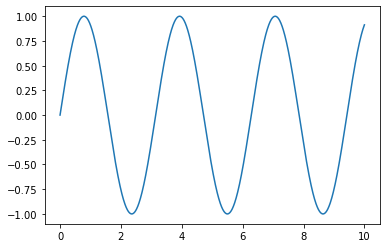

In [2]:
import numpy as np
x = np.linspace(0, 10, 1000)
y = 2 * np.sin(x) * np.cos(x)
plt.plot(x, y)

And here is the equivalent with `jax.numpy`:

In [3]:
plt.close()

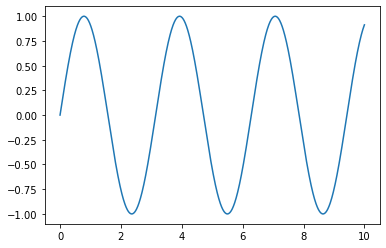

In [4]:
import jax.numpy as jnp
x = jnp.linspace(0, 10, 1000)
y = 2 * jnp.sin(x) * jnp.cos(x)
plt.plot(x, y)

The code blocks are identical aside from replacing `np` with `jnp`, and the results are the same.
As we can see, JAX arrays can often be used directly in place of NumPy arrays for things like plotting.

The arrays themselves are implemented as different Python types:

In [5]:
type(np.arange(10))

numpy.ndarray

In [6]:
type(jnp.arange(10))

jax.interpreters.xla._DeviceArray

Python's [duck-typing](https://en.wikipedia.org/wiki/Duck_typing>) allows JAX arrays and NumPy arrays
to be used interchangeably in many places.

However, there is one important difference between JAX and NumPy arrays: JAX arrays are immutable,
meaning that once created their contents cannot be changed.

Here is an example of mutating an array in Numpy:

In [7]:
x = np.arange(10) # NumPy: mutable arrays

In [8]:
x[0] = 10

In [9]:
x

array([10,  1,  2,  3,  4,  5,  6,  7,  8,  9])

The equivalent in JAX results in an error, as JAX arrays are immutable:

In [10]:
x = jnp.arange(10) # JAX: immutable arrays

In [11]:
x[0] = 10

TypeError: ignored

For updating individual elements, JAX provides an
[indexed update syntax](https://jax.readthedocs.io/en/latest/jax.ops.html#syntactic-sugar-for-indexed-update-operators)
that returns an updated copy:

In [12]:
x.at[0].set(10)

DeviceArray([10,  1,  2,  3,  4,  5,  6,  7,  8,  9], dtype=int32)

## NumPy, lax & XLA: JAX's layers of API

**Key Concepts:**

- `jax.numpy` is a high-level wrapper that provides a familiar interface.
- `jax.lax` is a lower-level API that is stricter and often more powerful.
- All JAX operations are implemented in terms of operations in
  [XLA](www.tensorflow.org/xla/)  – the Accelerated Linear Algebra compiler.

If you look at the source of `jax.numpy`, you'll see that all the operations are eventually
expressed in terms of functions defined in `jax.lax`.
You can think of `jax.lax` as a stricter, but often more powerful, API for working with
multi-dimensional arrays.

For example, `jax.numpy` will implicitly promote arguments to allow operations
between mixed data types:


In [13]:
import jax.numpy as jnp

In [14]:
jnp.add(1, 1.0) # jax.numpy API implicitly promotes mixed types.

DeviceArray(2., dtype=float32)

and `jax.lax` will not:

In [15]:
from jax import lax

In [16]:
lax.add(1, 1.0) # jax.lax API requires explicit type promotion.

TypeError: ignored

If using `jax.lax` directly, you'll have to do type promotion explicitly in such cases:

In [17]:
from jax import lax

In [18]:
lax.add(jnp.float32(1), 1.0)

DeviceArray(2., dtype=float32)

Along with this strictness, `jax.lax` also provides efficient APIs for some more
general operations than are supported by NumPy.

For example, consider a 1D convolution, which can be expressed in NumPy this way:

In [19]:
x = jnp.array([1, 2, 1])

In [20]:
y = jnp.ones(10)

In [21]:
jnp.convolve(x, y)

DeviceArray([1., 3., 4., 4., 4., 4., 4., 4., 4., 4., 3., 1.], dtype=float32)

Under the hood, this NumPy operation is translated to a much more general convolution implemented by
`jax.lax.conv_general_dilated`:

In [22]:
result = lax.conv_general_dilated(
    x.reshape(1, 1, 3).astype(float), #note: explicit promotion
    y.reshape(1, 1, 10),
    window_strides=(1,),
    padding=[(len(y) - 1, len(y) - 1)]) # equivalent of padding='full' in NumPy

In [23]:
result[0, 0]

DeviceArray([1., 3., 4., 4., 4., 4., 4., 4., 4., 4., 3., 1.], dtype=float32)

This is a batched convolution operation designed to be efficient for the types of convolutions often
used in deep neural nets. It requires much more boilerplate, but is far more flexible and scalable
than the convolution provided by NumPy (See
[JAX Sharp Bits: Convolutions](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#%F0%9F%94%AA-Convolutions)
for more detail on JAX convolutions).


## To JIT or not to JIT

**Key Concepts:**

- By default JAX executes operations one at a time, in sequence.
- Using a just-in-time (JIT) compilation decorator, sequences of operations can be optimized
  together and run at once.
- Not all JAX code can be JIT compiled, as it requires array shapes to be static and known at
  compile time.

The fact that all JAX operations are expressed in terms of XLA allows JAX to use the XLA
compiler to execute blocks of code very efficiently.

For example, consider this function that normalizes the rows of a 2D matrix,
expressed in terms of `jax.numpy` operations:

In [24]:
def norm(X):
  X = X - X.mean(0)
  return X / X.std(0)

A just-in-time compiled version of the function can be created using the `jax.jit` transform:

In [25]:
from jax import jit

In [26]:
norm_compiled = jit(norm)

This function returns the same results as the original, up to standard floating-point accuracy:

In [27]:
np.random.seed(1701)

In [28]:
X = jnp.array(np.random.rand(10000, 10))

In [29]:
np.allclose(norm(X), norm_compiled(X), atol=1E-6)

True

But due to the compilation (which includes fusing of operations, avoidance of allocating temporary
arrays, and a host of other tricks), execution times can be orders of magnitude faster in the 
JIT-compiled case (note the use of `~jax.xla.DeviceArray.block_until_ready`
to account for JAX's `async-dispatch`):

In [30]:
%timeit norm(X).block_until_ready()

100 loops, best of 3: 4.39 ms per loop


In [31]:
%timeit norm_compiled(X).block_until_ready()

1000 loops, best of 3: 382 µs per loop


That said, `jax.jit` does have limitations: in particular, it requires all arrays to have
static shapes. That means that some JAX operations are incompatible with JIT compilation.

For example, this operation can be executed in op-by-op mode:

In [32]:
def get_negatives(x):
  return x[x < 0]

In [33]:
x = jnp.array(np.random.randn(10))

In [34]:
get_negatives(x)

DeviceArray([-0.10570311, -0.59403396, -0.8680282 , -0.23489487], dtype=float32)

But it returns an error if you attempt to execute it in JIT mode:

In [35]:
jit(get_negatives)(x)

IndexError: ignored

This is because the function generates an array whose shape is not known at compile time:
the size of the output depends on the values of the input array, and so it is not compatible with JIT.

## JIT mechanics: tracing and static variables

**Key Concepts:**

- JIT and other JAX transforms work by *tracing* a function to determine its effect on inputs
  of a specific shape and type.
- Variables that you don't want to be traced can be marked as *static*

To use `jax.jit` effectively, it is useful to understand how it works.
Let's put a few `print()` statements within a JIT-compiled function and see what we find:

In [36]:
@jit
def f(x, y):
  print("Running f():")
  print(f"  x = {x}")
  print(f"  y = {y}")
  result = jnp.dot(x + 1, y + 1)
  print(f"  result = {result}")
  return result

The first time this function is run, what is printed is not the data we passed to the function,
but rather *tracer* objects that stand-in for them:

In [37]:
x = np.random.randn(3, 4)

In [38]:
y = np.random.randn(4)

In [39]:
f(x, y)

Running f():
  x = Traced<ShapedArray(float32[3,4])>with<DynamicJaxprTrace(level=0/1)>
  y = Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=0/1)>
  result = Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=0/1)>


DeviceArray([0.25773212, 5.3623195 , 5.4032435 ], dtype=float32)

These tracer objects are what `jax.jit` uses to extract the sequence of operations specified
by the function. Basic tracers are stand-ins that encode the **shape** and **dtype** of the arrays,
but are agnostic to the values. This recorded sequence of computations can then be efficiently
applied within XLA to new inputs with the same shape and dtype, without having to re-execute the
Python code.

When we call the compiled fuction again on matching inputs, no re-compilation is required:


In [40]:
x2 = np.random.randn(3, 4)

In [41]:
y2 = np.random.randn(4)

In [42]:
f(x2, y2)

DeviceArray([1.4344587, 4.3004417, 7.989701 ], dtype=float32)

The extracted sequence of operations is encoded in a JAX expression, or *jaxpr* for short.
You can view the jaxpr using the `jax.make_jaxpr` transformation:

In [43]:
from jax import make_jaxpr

In [44]:
def f(x, y):
  return jnp.dot(x + 1, y + 1)

In [45]:
make_jaxpr(f)(x, y)

{ lambda  ; a b.
  let c = add a 1.0
      d = add b 1.0
      e = dot_general[ dimension_numbers=(((1,), (0,)), ((), ()))
                       precision=None ] c d
  in (e,) }

Note one consequence of this: because JIT compilation is done *without* information on the content
of the array, control flow statements in the function cannot depend on traced values.
For example, this fails:

In [46]:
@jit
def f(x, neg):
  return -x if neg else x

In [47]:
f(1, True)

ConcretizationTypeError: ignored

If there are variables that you would not like to be traced,
they can be marked as static for the purposes of JIT compilation:

In [48]:
from functools import partial

In [49]:
@partial(jit, static_argnums=(1,))
def f(x, neg):
  return -x if neg else x

In [50]:
f(1, True)

DeviceArray(-1, dtype=int32)

Note that calling a JIT-compiled function with a different static argument results in re-compilation,
so the function still works as expected:

In [51]:
f(1, False)

DeviceArray(1, dtype=int32)

Understanding which values and operations will be static and which will be traced
is a key part of using `jax.jit` effectively.

## Static vs Traced Operations

**Key Concepts:**

- Just as values can be either static or traced, operations can be static or traced.

- Static operations are evaluated at compile-time in Python; traced operations are compiled
  and evaluated at run-time in XLA.

- Use `numpy` for operations that you want to be static; use `jax.numpy` for operations
  that you want to be traced.

This distinction between static and traced values makes it important to think about how to keep
a static value static. Consider this function:

In [52]:
@jit
def f(x):
  return x.reshape(jnp.array(x.shape).prod())

In [53]:
x = jnp.ones((2, 3))

In [54]:
f(x)

ConcretizationTypeError: ignored

This fails with an error specifying that a tracer was found in `jax.numpy.reshape`.
Let's add some print statements to the function to understand why this is happening:

In [55]:
@jit
def f(x):
  print(f"x = {x}")
  print(f"x.shape = {x.shape}")
  print(f"jnp.array(x.shape).prod() = {jnp.array(x.shape).prod()}")
  # comment this out to avoid the error:
  # return x.reshape(jnp.array(x.shape).prot())

In [56]:
f(x)

x = Traced<ShapedArray(float32[2,3])>with<DynamicJaxprTrace(level=0/1)>
x.shape = (2, 3)
jnp.array(x.shape).prod() = Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=0/1)>


Notice that although `x` is traced, `x.shape` is a static value. However, when we use
`jnp.array` and `jnp.prod` on this static value, it becomes a traced value, at
which point it cannot be used in a function like `jax.numpy.reshape` that requires a
static input (recall: array shapes must be static).

A useful pattern is to use `numpy` for operations that should be static (i.e. done at compile-time),
and use `jax.numpy` for operations that should be traced
(i.e. compiled and executed at run-time). For this function, it might look like this:

In [57]:
import jax.numpy as jnp

In [58]:
import numpy as np

In [59]:
@jit
def f(x):
  return x.reshape((np.prod(x.shape),))

In [60]:
f(x)

DeviceArray([1., 1., 1., 1., 1., 1.], dtype=float32)

For this reason, a standard convention in JAX programs is to `import numpy as np` and
`import jax.numpy as jnp` so that both interfaces are available for finer control over
whether operations are performed in a static matter (with `numpy`, once at compile-time) 
or a traced manner (with `jax.numpy`, optimized at run-time).